<a href="https://colab.research.google.com/github/IAScape/OSVision/blob/main/notebooks/OSVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OSRS Image detection module

## To Do:

- Collate function for batches

## Viz Utilities

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_prediction(img, prediction, tot_categories=100):
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, tot_categories)]
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for bbox, cat, prob in zip(prediction['boxes'], prediction['labels'],
                                prediction['scores']):  
        cat = int(cat)
        x1, y1, x2, y2 = bbox
        color = colors[cat]
        cat = categories[cat]
        box_h = abs(y2 - y1)
        box_w = abs(x2 - x1)
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                                    edgecolor=color, facecolor='none')

        plt.text(x1, y1, s=f"{cat} prob={prob}", color='white',
                    verticalalignment='top', bbox={'color': color, 'pad': 0})

        ax.add_patch(bbox)

    plt.axis('off')
    plt.show()

# Dataset

In [2]:
!git clone https://github.com/IAScape/datasets > /dev/null

Cloning into 'datasets'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 203 (delta 77), reused 180 (delta 65), pack-reused 0
Receiving objects: 100% (203/203), 20.04 MiB | 6.05 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [3]:
import os

path = 'datasets/OSVision/'
train_type = '02' # Catherby Agility

In [4]:
categories = dict()

cat_path = os.path.join(path, 'types', train_type, 'categories.txt')
with open(cat_path, 'r') as infile:
    for line in infile:
        code, name = line.strip().split(',')
        categories[int(code)] = name

In [5]:
import numpy as np
import torch
from PIL import Image
from lxml import etree
from torchvision import transforms


class OSVisionDataset(torch.utils.data.Dataset):
    def __init__(self, root, train_type, transform=True, train=True, resize=True):
        self.root = root
        self.train_type = train_type
        self.transform = transform
        self.img_ids, self.bound_boxes = self._load_ids(train)
        self.scales = dict()
        self.resize = resize

    def _load_ids(self, train):
        ids, bound_boxes = [], []
        if train:
            path = os.path.join(self.root,'types', self.train_type, 'train.txt')
        else: 
            path = os.path.join(self.root,'types', self.train_type, 'val.txt')
        with open(path) as infile:
            for line in infile:
                idx = line.strip()
                ids.append(idx)
                annot_path = os.path.join(self.root, 'annotations', f'{idx}.xml')
                doc = etree.parse(annot_path)
                boxes = []
                for obj in doc.findall('object'):
                    obj_dict = {}
                    obj_dict['labels'] = int(obj.find('name').text)
                    bnd_box = obj.find('bndbox')
                    x_min = int(bnd_box.find('xmin').text)
                    y_min = int(bnd_box.find('ymin').text)
                    x_max = int(bnd_box.find('xmax').text)
                    y_max = int(bnd_box.find('ymax').text)
                    obj_dict['boxes'] = (x_min, y_min, x_max, y_max)
                    boxes.append(obj_dict)
                bound_boxes.append(boxes)
        return ids, bound_boxes

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        image_path = os.path.join(self.root, 'img', f'{img_id}.png')
        image = Image.open(image_path).convert('RGB')
        target = {}
        bound_boxes = [obj['boxes'] for obj in self.bound_boxes[idx]]
        labels = [obj['labels'] for obj in self.bound_boxes[idx]]
        target['boxes'] = bound_boxes
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)

        if self.resize:
            # Get and save scale
            x_scale = 221 / image.size[0]
            y_scale = 221 / image.size[1]
            if not img_id in self.scales.keys():
                self.scales[img_id] = (x_scale, y_scale)
            image = image.resize((221, 221))
            target['boxes'] = [(t[0] * x_scale, t[1] * y_scale, t[2] * x_scale, t[3] * y_scale) for t in target['boxes']]
        if self.transform:
            transform_norm = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                            ])
            image = transform_norm(image)
        target['boxes'] = torch.Tensor(target['boxes'])
        return image, target

In [6]:
dataset_train = OSVisionDataset(path, train_type)
dataset_train_clean = OSVisionDataset(path, train_type, transform=False)
dataset_val = OSVisionDataset(path, train_type, train=False)
dataset_val_clean = OSVisionDataset(path, train_type, transform=False, train=False)

## Model

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
      
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

## Train

In [8]:
%%shell
git clone https://github.com/pytorch/vision.git > /dev/null
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 32676, done.
remote: Counting objects: 100% (5219/5219), done.
remote: Compressing objects: 100% (1130/1130), done.
remote: Total 32676 (delta 4167), reused 4988 (delta 3988), pack-reused 27457
Receiving objects: 100% (32676/32676), 39.24 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (24783/24783), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [9]:
import utils

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = max(categories.keys()) + 1

model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [11]:
import math
from tqdm import tqdm

def train_one_epoch(model, optimizer, data_loader, device, epoch, total_epoch):
    model.train()

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    cum_loss, cum_acc = 0.0, 0.0
    with tqdm(data_loader, unit='batch', position=0, leave=True) as tepoch:
        for n_batch, (images, targets) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}/{total_epoch} Train")

            images = list(image.to(device) for image in [images])

            targets = [{k: v.to(device) for k, v in t.items()} for t in [targets]]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())

            loss_dict_reduced = utils.reduce_dict(loss_dict)
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())

            loss_value = losses_reduced.item()

            cum_loss += loss_value

            current_cum_loss = cum_loss / n_batch

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if lr_scheduler is not None:
                lr_scheduler.step()

            tepoch.set_postfix(Loss=current_cum_loss)

In [12]:
num_epochs = 12

for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, optimizer, dataset_train, device, epoch, num_epochs)
    lr_scheduler.step()

Epoch 1/12 Train:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch 12/12 Train: 100%|██████████| 32/32 [00:02<00:00, 12.93batch/s, Loss=0.0975]


## Validate

In [13]:
import torchvision.transforms as T

def detect_objects(model, img, threshold=0.7):

    # Set model in evaluation mode
    img = img.unsqueeze(0)
    img = torch.Tensor(img).to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(img)[0]
    filtered_pred = {'boxes': [], 'labels': [], 'scores': []}
    # Filter predictions with threshold
    for box, cat, prob in zip(prediction['boxes'], prediction['labels'],
                                prediction['scores']):
        if prob > threshold:
            filtered_pred['boxes'].append(box)
            filtered_pred['labels'].append(cat)
            filtered_pred['scores'].append(round(float(prob), 3))
    return filtered_pred

In [14]:
def view_train(len='all'):
    if len != 'all': end = len - 1
    else: end == -1
    for i, (img, t) in enumerate(dataset_train):
        t['scores'] = [1 for _ in t['labels']]
        img = dataset_train_clean[i][0]
        plot_prediction(img, t)
        if end == i:
            break

<Figure size 432x288 with 0 Axes>

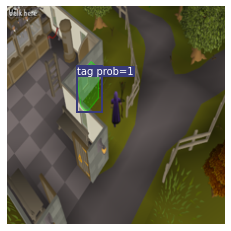

<Figure size 432x288 with 0 Axes>

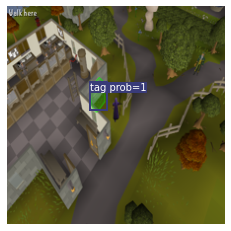

<Figure size 432x288 with 0 Axes>

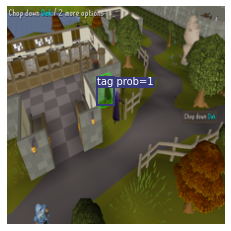

<Figure size 432x288 with 0 Axes>

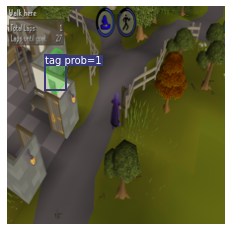

In [15]:
view_train(4)

In [16]:
def view_val(len='all'):
    if len == 'all': end = -1
    else: end = len - 1
    for i, (img, _) in enumerate(dataset_val):
        det = detect_objects(model, img, 0.5)
        l = [categories[c.item()] for c in det['labels']]
        img = dataset_val_clean[i][0]
        plot_prediction(img, det)
        if i == end:
            break

<Figure size 432x288 with 0 Axes>

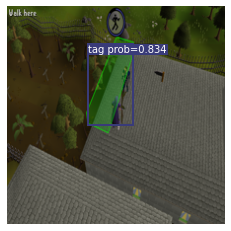

<Figure size 432x288 with 0 Axes>

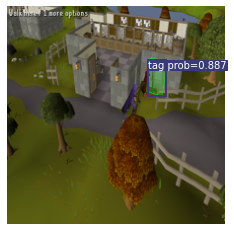

<Figure size 432x288 with 0 Axes>

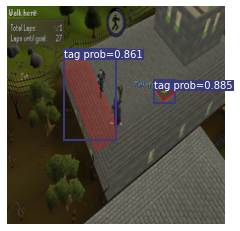

<Figure size 432x288 with 0 Axes>

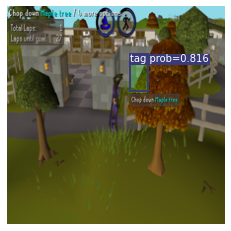

<Figure size 432x288 with 0 Axes>

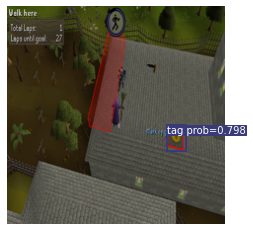

In [17]:
view_val()

In [18]:
def save_weigths(model, path):
    torch.save(model.state_dict(), path)

In [20]:
save_weigths(model, './cath_agility_1.pth')